# LTEM Image Simulation Example
A few examples showing how to simulate LTEM images from a given magnetization. 
  
Authors: Arthur McCray, CD Phatak
V1.0, ANL, May 2020

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook
import numpy as np
import sys 
sys.path.append("../PyTIE/")
from TIE_helper import *
from sim_helper import *
from TIE_reconstruct import TIE, SITIE
from comp_phase import mansPhi, linsupPhi

## Calculating the phase shift from a Bloch vortex with the Mansuripur algorithm  
This can only be applied to 2D magnetizations. For more details seee [this paper by Mansuripur](https://doi.org/10.1063/1.348682).   
It can be applied easily to island structures using the shape argument which takes a 2D binary array.  
std_mansPhi is for a a basic example with fixed materials parameters, but for most work one should call mansPhi directly. 

<IPython.core.display.Javascript object>


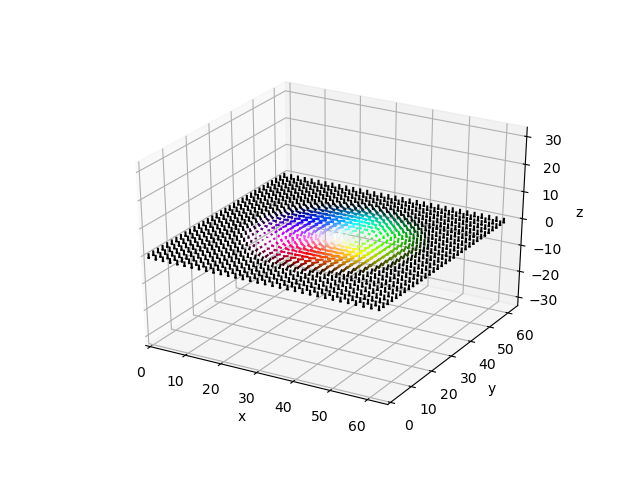

<IPython.core.display.Javascript object>


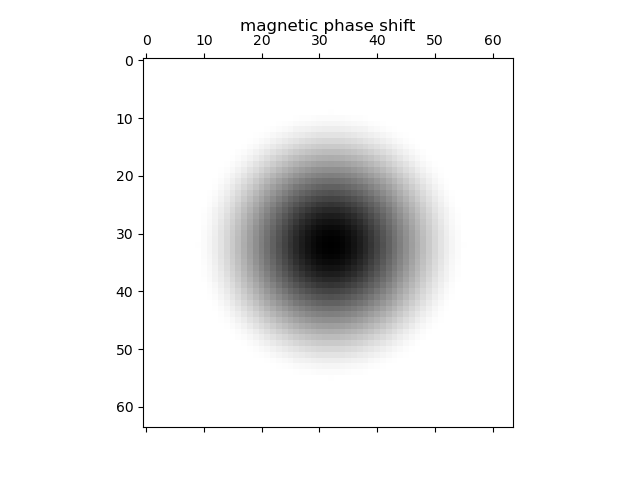

In [110]:
dim = 64
del_px = 10 # nm/pixel
Bloch_x, Bloch_y, Bloch_z = Bloch(dim, chirality = 'cw', pad = True, ir=0)
show_3D(Bloch_x, Bloch_y, Bloch_z, show_all = True, l=2, a = 50)

# Apply mansuripur algorithm with some standard materials parameters. 
ephi, mphi = std_mansPhi(Bloch_x, Bloch_y, del_px = del_px)
show_im(mphi, title="magnetic phase shift")

### Simulating LTEM images from the phase shift

Total fov is (640,640) nm


<IPython.core.display.Javascript object>


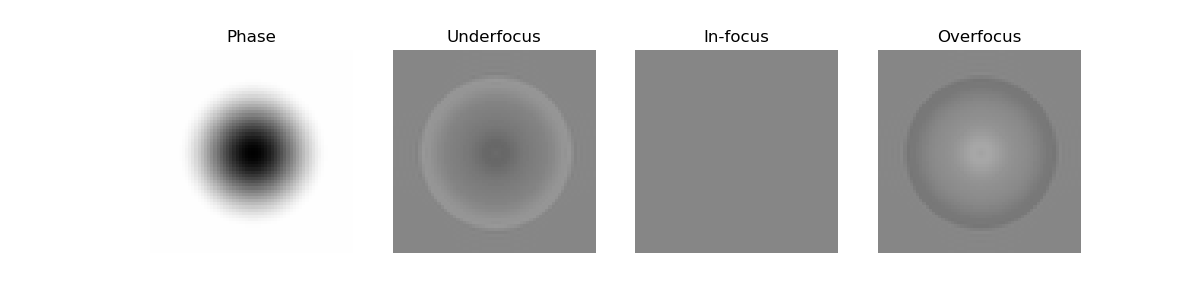

In [111]:
# Simulate LTEM images
pscope = Microscope(E=200e3,Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0)
defval = 50_000
Tphi, im_un, im_in, im_ov = sim_images(mphi=mphi, ephi=ephi, 
                                       pscope=pscope,
                                       del_px=del_px, 
                                       def_val=defval)
show_sims(Tphi, im_un, im_in, im_ov)

## Getting magnetic and electrostatic phase shift with the linear superposition method  
This method works with 3D magnetization structures but is slower. 

In [119]:
del_px = 10 # nm/pix
b0 = 1e4 #Gauss default 1e4
phi0 = 2.07e7 #Gauss*nm^2 
cb = b0/phi0*del_px**2 #1/px^2
pre_B = 2*np.pi*cb
ephi_L, mphi_L = linsupPhi(mx=Bloch_x.reshape(1,dim,dim),
                           my=Bloch_y.reshape(1,dim,dim),
                           mz=Bloch_z.reshape(1,dim,dim), 
                           Dshp=np.ones(Bloch_z.reshape(1,dim,dim).shape), 
                           pre_B=pre_B)

nelems =  4096
0.00%
100.00%


Total fov is (640,640) nm


<IPython.core.display.Javascript object>


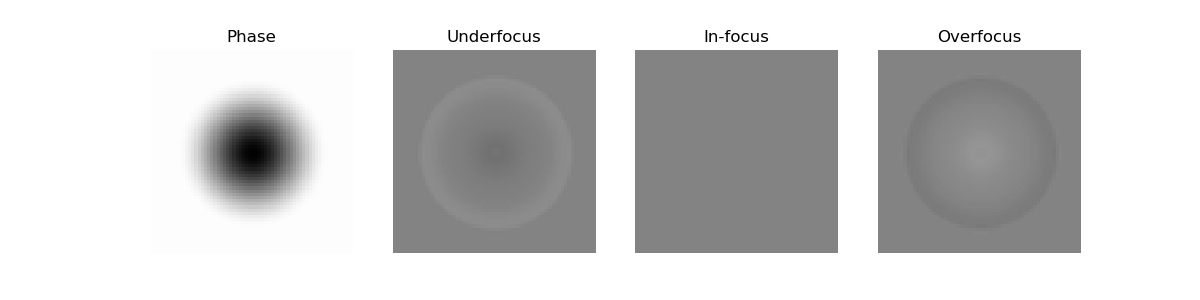

In [120]:
# Simulate LTEM images
pscope = Microscope(E=200e3,Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0)
defval = 50_000
Tphi, im_un, im_in, im_ov = sim_images(mphi=mphi_L, ephi=ephi_L, 
                                       pscope=pscope,
                                       del_px=del_px, 
                                       def_val=defval)
show_sims(Tphi, im_un, im_in, im_ov)

# Full example simulating and reconstructing images from a given magnetization

In [ ]:
# slightly larger image this time, using Mansuripur algorithm for speed
# and adding amorphous background contributions
pscope = Microscope(E=200e3,Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0)
dim = 512
del_px = 500/dim

Bloch_x, Bloch_y, Bloch_z = Bloch(dim, chirality = 'cw', pad = True)
ephi, mphi = std_mansPhi(Bloch_x, Bloch_y, del_px = del_px, pscope=pscope)

defval = 100_000
Tphi, im_un, im_in, im_ov = sim_images(mphi = mphi, ephi = ephi, 
                                       pscope = pscope,
                                       del_px = del_px, 
                                       def_val = defval,
                                       add_random = 1)


In [ ]:
show_sims(Tphi, im_un, im_in, im_ov)

### Reconstructing with full TIE  
Uniformly thin film, so no need for a flip stack. 

In [ ]:
pscope = Microscope(E=200e3, Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0)
ptie = TIE_params(imstack=[im_un, im_in, im_ov], defvals=[defval], flip=False, no_mask=True)
ptie.set_scale(del_px)

i = 0 
dataname = f'Example_Bloch' 
sym = False
qc = False
save = False

results = TIE(i, ptie, pscope, 
                     dataname = dataname, 
                     sym=sym, 
                     qc = qc, 
                     save=save)

#### Comparing the reconstructed phase to the simulated values
If this sample were not simulated as being uniformly flat (which we could do using the isl_shape parameter), we would have needed to calculate a flip stack by simulating images with ephi=ephi and mphi=-1\*mphi, and done a full TIE reconstruction with the unflip and flip stacks. 

In [ ]:
# (total phase shift reconstructed) / (magnetic phase shift simulated)
(np.max(results["phase_m"])-np.min(results["phase_m"]))/(np.max(mphi)-np.min(mphi))

### Single Image TIE (SITIE) Reconstruction 
Example showing how this magnetization can be reconsutructed from a single image.  
This can be applied to experimental images that are uniformly flat, thin, and with only magnetic contrast.  
For more information see [this paper by Chess et. al](https://doi.org/10.1016/j.ultramic.2017.02.004). 

In [ ]:
pscope = Microscope(E=200e3, Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0)
ptie_SITIE = TIE_params(im_ov, [], defval)
ptie_SITIE.set_scale(del_px)

dataname = 'Example_SITIE_Bloch' 
sym = False
qc = False
save = False

results = SITIE(ptie_SITIE, pscope, 
                     dataname = dataname, 
                     sym=sym, 
                     qc = qc, 
                     save=save)

#### This can also be done with the original ptie, selecting image with an index from the imstack. 

In [ ]:
results = SITIE(ptie, pscope, 
                     dataname = dataname, 
                     sym=sym, 
                     qc = qc, 
                     save=save,
                     i=0) # for i=1 will try to reconstruct the infocus image and won't work. 

# Simulating LTEM images of micromagnetics output 
Depending on the simulation software used, the magnetization will need to be scaled appropriately. Set the "sim" argument depending on what was used:  
- 'oommf' : outputs are in A/m so scaled by mu0
- 'mumax' : outputs are normalized \[-1,1\] so scaled by Msat
- 'raw'   : outputs are passed without scaling

In [76]:
# file = "path/to/file.omf"
file = "C:/Users/arthu/Box Sync/my_box/mag_simulation/OOMMF/nyro_out/5e-07_top_5e+06_5e+04_1e+02_Ms3.4e+05/5e-07_top_5e+06_5e+04_1e+02_Ms3.4e+05-Oxs_TimeDriver-Magnetization-06-0001921.omf"
# file = "C:/Users/arthu/Desktop/example_binary.ovf"
# file = "C:/Users/arthu/Desktop/m000004.ovf"

mag_x, mag_y, mag_z, del_px, zscale = load_ovf(file, sim="oommf")

Text file found
Simulation size (z, y, x) : (2, 200, 200)
Image scale : 5 nm/pixel.
Scaling for OOMMF output.


#### Micromagnetic simulated data will generally be 3D, and to allow for easy simulation of tilted samples we use the linear superposition method for simulating the phase shifts.   
The mean inner potential of the sample is only used for calculating the electrostatic phase shift in conjunction with the shape of the sample (given in the array Dshp). For uniform thickness films it adds only a constant offset and is therefore irrelevent for the LTEM simulations. 

In [62]:
# material parameters
b0 = 1e4
phi0 = 2.07e7 #Gauss*nm^2 
pre_B = 2*np.pi*b0/phi0*zscale**2 #1/px^2
V0 = 10 # mean inner potential
shape = np.ones(mag_z.shape) # shape function, given here as uniform


# imaging parameters
kvscope = Microscope(E=200e3) # only energy is relevant for phase shift
theta_x = 0 # rotation around x axis (degrees)
theta_y = 0 # rotation around y axis (degrees)

ephi, mphi = linsupPhi(mx=mag_x, 
                           my=mag_y,
                           mz=mag_z, 
                           Dshp=shape,
                           theta_x=theta_x,
                           theta_y=theta_y,
                           pre_B=pre_B,
                           pre_E=kvscope.sigma*V0)

nelems =  80000
0.00%
2.12%
4.36%
6.64%


KeyboardInterrupt: 

#### Simulating the images from the phase shift  
Here you can set the exact microscope parameters used to simulate the images. 

In [82]:
(ephi, mphi )= std_mansPhi(mag_x=mag_x[0], mag_y=mag_y[0], del_px=del_px, isl_shape=None, pscope=pscope, 
                           b0=1e4, isl_thk=20, isl_V0=20, mem_thk=0, mem_V0=0)

In [83]:
defval = 100_000 # nm
pscope = Microscope(E=200e3, Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0, verbose=False)

Tphi, im_un, im_in, im_ov = sim_images(mphi = mphi, ephi = ephi, 
                                       pscope = pscope,
                                       del_px = del_px, 
                                       def_val = defval,
                                       add_random = 0)


Total fov is (1000.0,1000.0) nm


<IPython.core.display.Javascript object>


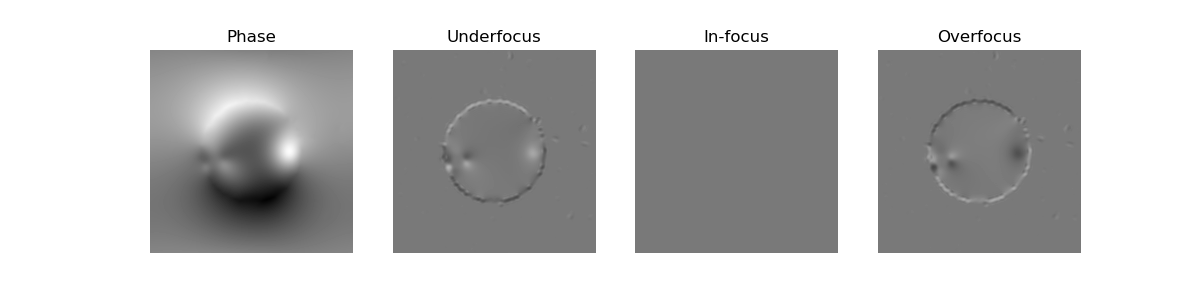

In [84]:
show_sims(Tphi, im_un, im_in, im_ov)

<IPython.core.display.Javascript object>


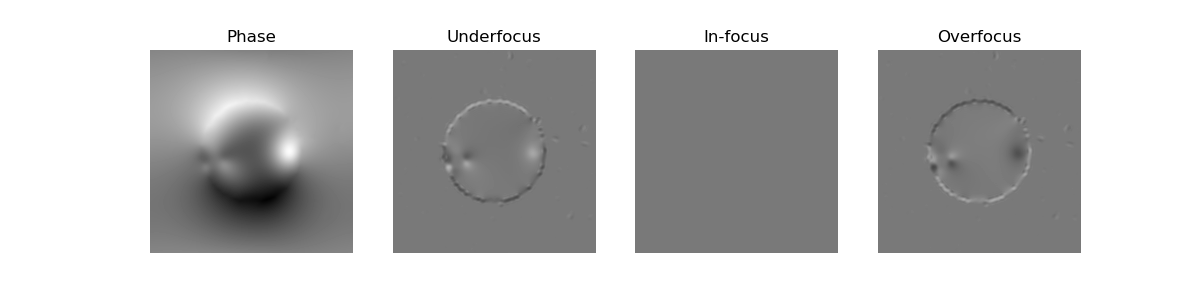

In [81]:
show_sims(Tphi, im_un, im_in, im_ov)

In [60]:
file = "C:/Users/arthu/Box Sync/my_box/mag_simulation/OOMMF/nyro_out/5e-07_top_5e+06_5e+04_1e+02_Ms3.4e+05/5e-07_top_5e+06_5e+04_1e+02_Ms3.4e+05-Oxs_TimeDriver-Magnetization-06-0001921.omf"
# material parameters
Msat = 1e4 # gauss
V0 = 10 # mean inner potential (V)
xip0 = 50 # extinction distance (nm)
shape = None # -> np.ones(mag_z.shape) # shape function, given here as uniform

pscope = Microscope(E=200e3, Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0, verbose=False)
defval = 100_000
theta_x = 0
theta_y = 0

reconstruct_ovf(file=file, save=1, sim='oommf', v=1, flip=True, shape=shape, pscope=pscope,
               defval=defval, theta_x=theta_x, theta_y=theta_y, Msat=Msat, V0=V0,
               add_random=0, xip0=xip0)

savename is:  5e-07_top_5e+06_5e+04_1e+02_Ms3.4e+05-Oxs_TimeDriver-Magnetization-06-0001921
Text file found
Simulation size (z, y, x) : (2, 200, 200)
Image scale : 5 nm/pixel.
Scaling for OOMMF output.
nelems =  80000
0.00%


KeyboardInterrupt: 

Data not given in hyperspy signal class. You likely need to set ptie.scale (nm/pix).
Given scale: 1.0000 nm/pix

Aligning for defocus value:  100000  with only unflip tfs.
Reconstructing with normal Laplacian method
Calling TIE solver



<IPython.core.display.Javascript object>


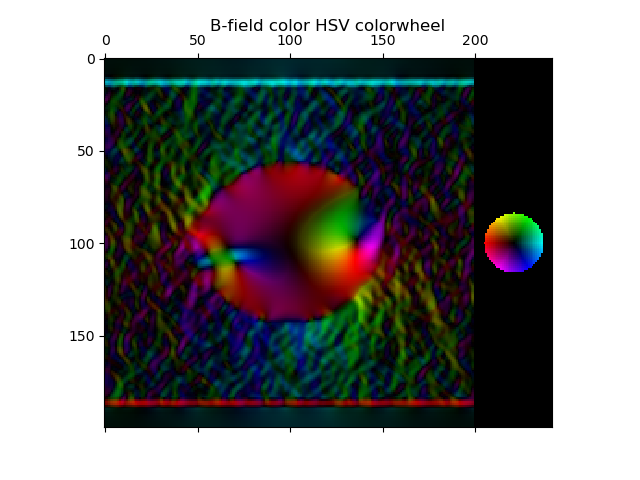

Phase reconstruction completed.


In [434]:
ptie = TIE_params(imstack=[im_un, im_in, im_ov], defvals=[defval], flip=False, no_mask=True)
ptie.set_scale(del_px)

i = 0 
dataname = f'Example_omf' 
sym = False
qc = False
save = False

results = TIE(i, ptie, pscope, 
                     dataname = dataname, 
                     sym=sym, 
                     qc = qc, 
                     save=save)

<IPython.core.display.Javascript object>


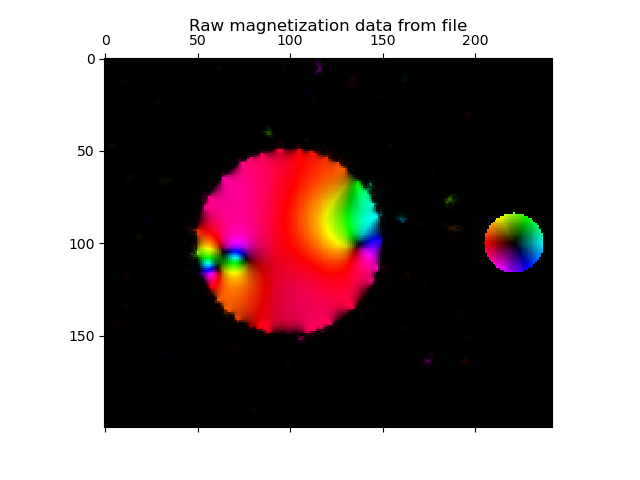

In [341]:
from colorwheel import color_im
show_im(color_im(np.sum(mag_x, axis=0), np.sum(mag_y,axis=0),hsvwheel=True), "Raw magnetization data from file")

## Examples creating single layer skyrmion magnetization structures
You can click and drag to turn the show3D figures. 

In [ ]:
dim = 64
Bloch_x2, Bloch_y2, Bloch_z2 = Lillihook(dim, Q = 1, gamma=3*np.pi/2)
show_3D(Bloch_x2, Bloch_y2, Bloch_z2, show_all = True, l=2, a = 50)

In [ ]:
anti_x, anti_y, anti_z = Lillihook(dim, rad=dim//4, Q = -1, show=False)
show_3D(anti_x, anti_y, anti_z, show_all = False, l=5, a = 25)
show_2D(anti_x, anti_y, l=3, a = 50)

--- End Notebook ---